In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import stats as st
import numpy as np
pd.options.mode.chained_assignment = None
df1 = pd.read_csv('/datasets/calls.csv')
df2 = pd.read_csv('/datasets/internet.csv')
df3 = pd.read_csv('/datasets/messages.csv')
df4 = pd.read_csv('/datasets/tariffs.csv')
df5 = pd.read_csv('/datasets/users.csv')
df4.columns.values[7] = 'tariff'

In [2]:

data1 = df5.merge(df4, on='tariff', how='outer')
data2 = df1.merge(df2, on='id', how='outer')
data3 = data2.merge(df3, on='id', how='outer')
data3['user_id'] = data3['user_id'].fillna(value=data3['user_id_y'])
data3['user_id'] = data3['user_id'].fillna(value=data3['user_id_x'])
data = data1.merge(data3, on='user_id', how='outer')
data = data.drop(['user_id_x', 'user_id_y'], 1)

data = data[[
    'user_id', 'first_name', 'last_name', 'city', 'age', 'reg_date', 
    'churn_date', 'id', 'call_date', 'duration', 'session_date', 'mb_used', 
    'message_date', 'tariff', 'messages_included', 'mg_per_month_included', 
    'minutes_included', 'rub_monthly_fee', 'rub_per_message', 'rub_per_gb', 'rub_per_minute'
]]

data['reg_date'] = pd.to_datetime(data['reg_date'], format='%Y-%m-%d')
data['call_date'] = pd.to_datetime(data['call_date'], format='%Y-%m-%d')
data['session_date'] = pd.to_datetime(data['session_date'], format='%Y-%m-%d')
data['message_date'] = pd.to_datetime(data['message_date'], format='%Y-%m-%d')
data['churn_date'] = pd.to_datetime(data['churn_date'], format='%Y-%m-%d')

data.tail(5)

,user_id,first_name,last_name,city,age,reg_date,churn_date,id,call_date,duration,...,mb_used,message_date,tariff,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_message,rub_per_gb,rub_per_minute
237276,1499,Гектор,Корнилов,Пермь,35,2018-09-27,NaT,1499_215,2018-12-26,0.76,...,NaN,NaT,smart,50,15360,500,550,3,200,3
237277,1499,Гектор,Корнилов,Пермь,35,2018-09-27,NaT,1499_216,2018-10-18,18.83,...,NaN,NaT,smart,50,15360,500,550,3,200,3
237278,1499,Гектор,Корнилов,Пермь,35,2018-09-27,NaT,1499_217,2018-11-10,10.81,...,NaN,NaT,smart,50,15360,500,550,3,200,3
237279,1499,Гектор,Корнилов,Пермь,35,2018-09-27,NaT,1499_218,2018-10-06,4.27,...,NaN,NaT,smart,50,15360,500,550,3,200,3
237280,1499,Гектор,Корнилов,Пермь,35,2018-09-27,NaT,1499_219,2018-12-14,19.62,...,NaN,NaT,smart,50,15360,500,550,3,200,3


Шаг 2.
Я сложила все таблицы в одну, вроде, никакие данные не потерялись за счет "how='outer'". Удалила лишние столбцы, вывела по удобному порядку датафрейм. Привела все даты к нормальному формату. Звонки длительностью 0,00 скорее всего пропущенные или недозвон. Такие звонки учитываются только если включены в роуминг. у нас таких данных нет.

1. Количество сделанных звонков и израсходованных минут разговора по месяцам

In [3]:
data['month_name'] = data['call_date'].dt.month_name()
data['month_index'] = data['call_date'].dt.month
data_call = data.pivot_table(index=['month_index', 'month_name'], values='duration', aggfunc=['count', 'sum', 'mean']).sort_values('month_index')
data_call

,,count,sum,mean
,,duration,duration,duration
month_index,month_name,,,
1.0,January,1476,10206.44,6.914932
2.0,February,3328,23145.58,6.954802
3.0,March,6687,45433.85,6.794355
4.0,April,9272,62530.92,6.744060
5.0,May,12647,83770.77,6.623766
6.0,June,14716,99249.71,6.744340
7.0,July,18298,124373.23,6.797094
8.0,August,21488,145071.63,6.751286


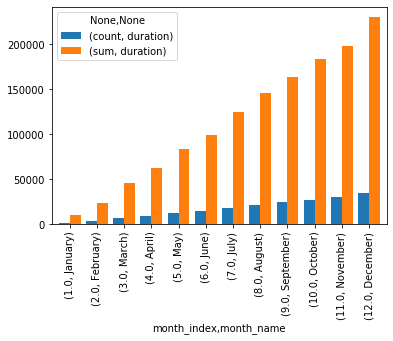

In [4]:
data_call.plot(kind='bar', y=[('count', 'duration'), ('sum', 'duration')], width=0.8, legend=True)

Среднее значение для тарифа Смарт: 6.75
Стандартное отклонение для тарифа Смарт: 5.84
Дисперсия для тарифа Смарт: 34.13

Среднее значение для тарифа Ультра: 6.77
Стандартное отклонение для тарифа Ультра: 5.85
Дисперсия для тарифа Ультра: 34.17


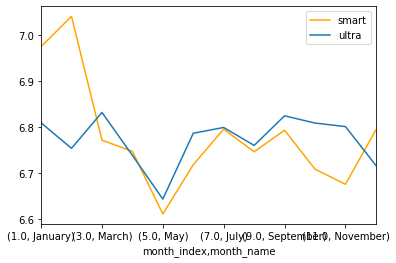

In [5]:
data_smart = data[data['tariff'] == 'smart']
data_ultra = data[data['tariff'] == 'ultra']
data_smart_call = data_smart.pivot_table(index=['month_index', 'month_name'], values='duration', aggfunc=['mean']).sort_values('month_index')
data_ultra_call = data_ultra.pivot_table(index=['month_index', 'month_name'], values='duration', aggfunc=['mean']).sort_values('month_index')

ax = data_smart_call.plot(kind='line', linestyle='-', y=('mean', 'duration'), color='orange', label='smart')
data_ultra_call.plot(kind='line', linestyle='-', y=('mean', 'duration'), ax=ax, label='ultra')

print('Среднее значение для тарифа Смарт: {:.2f}'.format(data_smart['duration'].mean()))
print('Стандартное отклонение для тарифа Смарт: {:.2f}'.format(data_smart['duration'].describe()[2]))
print('Дисперсия для тарифа Смарт: {:.2f}'.format((data_smart['duration'].describe()[2])**2))
print()
print('Среднее значение для тарифа Ультра: {:.2f}'.format(data_ultra['duration'].mean()))
print('Стандартное отклонение для тарифа Ультра: {:.2f}'.format(data_ultra['duration'].describe()[2]))
print('Дисперсия для тарифа Ультра: {:.2f}'.format((data_ultra['duration'].describe()[2])**2))


Количество звонков равномерно растет. Посмотрев среднее значение по 2м тарифам, мы видим, что среднее время разговора примерно одинаковое. Стандартное отклонение тоже практически симметрично. На разговоры вне зависимости от тарифа люди тратят примерно одинаковое количество времени.

2. Количество отправленных сообщений по месяцам

In [6]:
data['month_name'] = data['message_date'].dt.month_name()
data['month_index'] = data['message_date'].dt.month
data_message = data.pivot_table(index=['month_index', 'month_name'], values='message_date', aggfunc=['count']).sort_values('month_index')
data_message

,,count
,,message_date
month_index,month_name,
1.0,January,924
2.0,February,1924
3.0,March,3648
4.0,April,5179
5.0,May,7298
6.0,June,8983
7.0,July,11320
8.0,August,13088


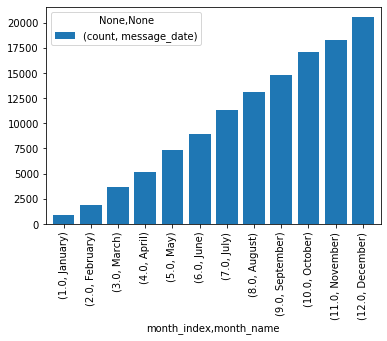

In [7]:
data_message.plot(kind='bar', width=0.8)

Пока в интернете пишут, что сообщения вытесняются месенджерами, в компании «Мегалайн» пользователи все активнее и активнее от месяца к месяцу пользуются данной функцией.

3. Объем израсходованного интернет-трафика по месяцам

In [8]:
data['month_name'] = data['session_date'].dt.month_name()
data['month_index'] = data['session_date'].dt.month
data_mb = data.pivot_table(index=['month_index', 'month_name'], values='mb_used', aggfunc=['sum', 'mean']).sort_values('month_index')
data_mb

,,sum,mean
,,mb_used,mb_used
month_index,month_name,,
1.0,January,407732.53,365.024646
2.0,February,955251.65,361.700738
3.0,March,1811835.61,370.897771
4.0,April,2433311.62,373.723179
5.0,May,3525862.24,374.772772
6.0,June,4180017.17,378.042613
7.0,July,5029478.75,371.234038
8.0,August,5998157.07,372.741553


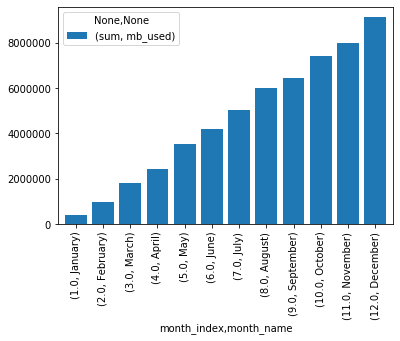

In [9]:
data_mb.plot(kind='bar', y=('sum', 'mb_used'), width=0.8)

Среднее значение для тарифа Смарт: 323.91
Стандартное отклонение для тарифа Смарт: 259.45
Дисперсия для тарифа Смарт: 67312.53

Среднее значение для тарифа Ультра: 506.56
Стандартное отклонение для тарифа Ультра: 287.09
Дисперсия для тарифа Ультра: 82418.70


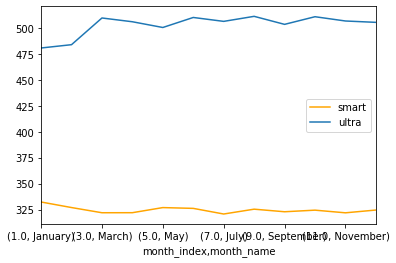

In [10]:
data_smart = data[data['tariff'] == 'smart']
data_ultra = data[data['tariff'] == 'ultra']
data_smart_mb = data_smart.pivot_table(index=['month_index', 'month_name'], values='mb_used', aggfunc=['mean']).sort_values('month_index')
data_ultra_mb = data_ultra.pivot_table(index=['month_index', 'month_name'], values='mb_used', aggfunc=['mean']).sort_values('month_index')

ax = data_smart_mb.plot(kind='line', linestyle='-', y=('mean', 'mb_used'), color='orange', label='smart')
data_ultra_mb.plot(kind='line', linestyle='-', y=('mean', 'mb_used'), ax=ax, label='ultra')

print('Среднее значение для тарифа Смарт: {:.2f}'.format(data_smart['mb_used'].mean()))
print('Стандартное отклонение для тарифа Смарт: {:.2f}'.format(data_smart['mb_used'].describe()[2]))
print('Дисперсия для тарифа Смарт: {:.2f}'.format((data_smart['mb_used'].describe()[2])**2))
print()
print('Среднее значение для тарифа Ультра: {:.2f}'.format(data_ultra['mb_used'].mean()))
print('Стандартное отклонение для тарифа Ультра: {:.2f}'.format(data_ultra['mb_used'].describe()[2]))
print('Дисперсия для тарифа Ультра: {:.2f}'.format((data_ultra['mb_used'].describe()[2])**2))

Интернетом пользуются все больше и больше к каждому месяцу. А вот по среднему значению и стандартному отклонению мы видим, что на Ультре пользователь гораздо активнее пользуютсяинтернетом, чем на тарифе Смарта, что и естественно, исходя из условий тарифа.

4. Помесячная выручка с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана)

In [11]:
data['call_date'] = data['call_date'].fillna(value=data['reg_date'])
data['call_date'] = pd.to_datetime(data['call_date'])
data['month_name'] = data['call_date'].dt.month_name()
data['month_index'] = data['call_date'].dt.month
data_smart = data[data['tariff'] == 'smart']
data_ultra = data[data['tariff'] == 'ultra']

In [12]:
minutes_included_smart = 500
rub_per_minute_smart = 3

data_smart_calls_rev = (
    data_smart.pivot_table(index=['user_id', 'last_name'], columns='month_name', values=['duration'], aggfunc='sum')
    .fillna(0)
    .sort_values('last_name')
)

for i in range(len(data_smart_calls_rev.values)):
    for j in range(12):
        data_smart_calls_rev.values[i][j] = math.ceil(data_smart_calls_rev.values[i][j])

data_smart_calls_rev.columns = data_smart_calls_rev.columns.droplevel(0)
data_smart_calls_rev_new = data_smart_calls_rev.values - minutes_included_smart

for i in range(len(data_smart_calls_rev_new)):
    for j in range(12):
        if data_smart_calls_rev_new[i][j] > 0:
            data_smart_calls_rev_new[i][j] = data_smart_calls_rev_new[i][j]*rub_per_minute_smart
        if data_smart_calls_rev_new[i][j] <= 0:
            data_smart_calls_rev_new[i][j] = 0

data_smart_calls_rev_new = pd.DataFrame(data=data_smart_calls_rev_new, 
                        index=data_smart_calls_rev.index,
                        columns = data_smart_calls_rev.columns)
data_smart_calls_rev_new

,month_name,April,August,December,February,January,July,June,March,May,November,October,September
user_id,last_name,,,,,,,,,,,,
1465,Ёркин,0.0,60.0,186.0,0.0,0.0,387.0,240.0,0.0,0.0,597.0,0.0,288.0
1345,Ёркина,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1459,Ёрохов,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,366.0,0.0,0.0
1239,Ёрохов,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,324.0,0.0,0.0
1302,Абаимов,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1186,Абакумов,0.0,228.0,372.0,72.0,0.0,165.0,204.0,0.0,111.0,111.0,0.0,390.0
1087,Абалакова,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1484,Абалдуева,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1359,Абашкин,0.0,429.0,567.0,0.0,0.0,0.0,0.0,0.0,0.0,618.0,408.0,0.0


In [13]:
minutes_included_ultra = 3000
rub_per_minute_ultra = 1

data_ultra_calls_rev = (
    data_ultra.pivot_table(index=['user_id', 'last_name'], columns='month_name', values=['duration'], aggfunc='sum')
    .fillna(0)
    .sort_values('last_name')
)

for i in range(len(data_ultra_calls_rev.values)):
    for j in range(12):
        data_ultra_calls_rev.values[i][j] = math.ceil(data_ultra_calls_rev.values[i][j])

data_ultra_calls_rev.columns = data_ultra_calls_rev.columns.droplevel(0)
data_ultra_calls_rev_new = data_ultra_calls_rev.values - minutes_included_ultra

for i in range(len(data_ultra_calls_rev_new)):
    for j in range(12):
        if data_ultra_calls_rev_new[i][j] > 0:
            data_ultra_calls_rev_new[i][j] = data_ultra_calls_rev_new[i][j]*rub_per_minute_ultra
        if data_ultra_calls_rev_new[i][j] <= 0:
            data_ultra_calls_rev_new[i][j] = 0

data_ultra_calls_rev_new = pd.DataFrame(data=data_ultra_calls_rev_new, 
                        index=data_ultra_calls_rev.index,
                        columns = data_ultra_calls_rev.columns)
data_ultra_calls_rev_new

,month_name,April,August,December,February,January,July,June,March,May,November,October,September
user_id,last_name,,,,,,,,,,,,
1416,Ёлчина,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1424,Ёрохова,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1303,Абакшина,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1452,Абалдуева,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1469,Абалкин,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1096,Абашкина,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1167,Абдулина,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1120,Абдулина,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1399,Абрашина,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
data_calls_rev_new = data_smart_calls_rev_new.merge(data_ultra_calls_rev_new, on=['user_id', 'last_name', 'April', 'August', 'December', 'February', 'January', 'July', 'June',
       'March', 'May', 'November', 'October', 'September'], how='outer').sort_values('last_name')
print(data_smart_calls_rev_new.sum())
print(data_ultra_calls_rev_new.sum())

month_name
April         6420.0
August       21357.0
December     53634.0
February      1632.0
January         84.0
July         14526.0
June          9960.0
March         5676.0
May           8127.0
November     30639.0
October      29223.0
September    24753.0
dtype: float64
month_name
April        0.0
August       0.0
December     0.0
February     0.0
January      0.0
July         0.0
June         0.0
March        0.0
May          0.0
November     0.0
October      0.0
September    0.0
dtype: float64


Путем долгих вычислений посчитала помесячную выручку с каждого пользователя за звонки сверх лимита. По тарифу Смарт людям не хватает минут, включенных в тариф. А по тарифу Ультра все в порядке, все вписываются в лимит.

In [15]:
messages_included_smart = 50
rub_per_message_smart = 3

data['month_name'] = data['message_date'].dt.month_name()
data['month_index'] = data['message_date'].dt.month

data_smart_messages_rev = (
    data_smart.pivot_table(index=['user_id', 'last_name'], columns='month_name', values=['message_date'], aggfunc='count')
    .fillna(0)
    .sort_values('last_name')
)

data_smart_messages_rev.columns = data_smart_messages_rev.columns.droplevel(0)
data_smart_messages_rev_new = data_smart_messages_rev.values - messages_included_smart

for i in range(len(data_smart_messages_rev_new)):
    for j in range(12):
        if data_smart_messages_rev_new[i][j] > 0:
            data_smart_messages_rev_new[i][j] = data_smart_messages_rev_new[i][j]*rub_per_message_smart
        if data_smart_messages_rev_new[i][j] <= 0:
            data_smart_messages_rev_new[i][j] = 0

data_smart_messages_rev_new = pd.DataFrame(data=data_smart_messages_rev_new, 
                        index=data_smart_messages_rev.index,
                        columns = data_smart_messages_rev.columns)
data_smart_messages_rev_new

,month_name,April,August,December,February,January,July,June,March,May,November,October,September
user_id,last_name,,,,,,,,,,,,
1465,Ёркин,0.0,12.0,30.0,0.0,0.0,24.0,0.0,0.0,0.0,33.0,0.0,15.0
1345,Ёркина,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1459,Ёрохов,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1239,Ёрохов,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1302,Абаимов,0.0,0.0,0.0,0.0,1398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1186,Абакумов,27.0,45.0,81.0,9.0,0.0,54.0,33.0,0.0,24.0,18.0,33.0,30.0
1087,Абалакова,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1484,Абалдуева,0.0,945.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0
1359,Абашкин,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
messages_included_ultra = 1000
rub_per_message_ultra = 1

data['month_name'] = data['message_date'].dt.month_name()
data['month_index'] = data['message_date'].dt.month

data_ultra_messages_rev = (
    data_ultra.pivot_table(index=['user_id', 'last_name'], columns='month_name', values=['message_date'], aggfunc='count')
    .fillna(0)
    .sort_values('last_name')
)

data_ultra_messages_rev.columns = data_ultra_messages_rev.columns.droplevel(0)
data_ultra_messages_rev_new = data_ultra_messages_rev.values - messages_included_ultra

for i in range(len(data_ultra_messages_rev_new)):
    for j in range(12):
        if data_ultra_messages_rev_new[i][j] > 0:
            data_ultra_messages_rev_new[i][j] = data_ultra_messages_rev_new[i][j]*rub_per_message_ultra
        if data_ultra_messages_rev_new[i][j] <= 0:
            data_ultra_messages_rev_new[i][j] = 0

data_ultra_messages_rev_new = pd.DataFrame(data=data_ultra_messages_rev_new, 
                        index=data_ultra_messages_rev.index,
                        columns = data_ultra_messages_rev.columns)
data_ultra_messages_rev_new

,month_name,April,August,December,February,January,July,June,March,May,November,October,September
user_id,last_name,,,,,,,,,,,,
1416,Ёлчина,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1424,Ёрохова,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1303,Абакшина,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1452,Абалдуева,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1469,Абалкин,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1096,Абашкина,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1167,Абдулина,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1120,Абдулина,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1399,Абрашина,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
data_messages_rev_new = data_smart_messages_rev_new.merge(data_ultra_messages_rev_new, on=['user_id', 'last_name', 'April', 'August', 'December', 'February', 'January', 'July', 'June',
       'March', 'May', 'November', 'October', 'September'], how='outer').sort_values('last_name')
print(data_smart_messages_rev_new.sum())
print(data_ultra_messages_rev_new.sum())

month_name
April        3489.0
August       4326.0
December     4077.0
February     3252.0
January      4995.0
July         3459.0
June         2364.0
March        2463.0
May          5049.0
November     3609.0
October      3870.0
September    3333.0
dtype: float64
month_name
April          0.0
August         0.0
December       0.0
February      40.0
January        0.0
July           0.0
June           0.0
March          0.0
May          409.0
November       0.0
October        0.0
September      0.0
dtype: float64


Это помесячная выручка с каждого пользователя за сообщения сверх лимита. У Смарта проблема с сообщениями. Их явно нехватает пользователю. А во по Ультре никаких проблем и никакого лишнего дохода для компании.

In [18]:
mb_per_month_included_smart = 15*1024
rub_per_gb_smart = 200

data['month_name'] = data['session_date'].dt.month_name()
data['month_index'] = data['session_date'].dt.month

data_smart_mb_rev = (
    data_smart.pivot_table(index=['user_id', 'last_name'], columns='month_name', values=['mb_used'], aggfunc='sum')
    .fillna(0)
    .sort_values('last_name')
)

for i in range(len(data_smart_mb_rev.values)):
    for j in range(12):
        data_smart_mb_rev.values[i][j] = math.ceil(data_smart_mb_rev.values[i][j])

data_smart_mb_rev.columns = data_smart_mb_rev.columns.droplevel(0)
data_smart_mb_rev_new = data_smart_mb_rev.values - mb_per_month_included_smart

for i in range(len(data_smart_mb_rev_new)):
    for j in range(12):
        if data_smart_mb_rev_new[i][j] > 0:
            data_smart_mb_rev_new[i][j] = math.ceil(data_smart_mb_rev_new[i][j]/1024)*rub_per_gb_smart
        if data_smart_mb_rev_new[i][j] <= 0:
            data_smart_mb_rev_new[i][j] = 0

data_smart_mb_rev_new = pd.DataFrame(data=data_smart_mb_rev_new, 
                        index=data_smart_mb_rev.index,
                        columns = data_smart_mb_rev.columns)
data_smart_mb_rev_new

,month_name,April,August,December,February,January,July,June,March,May,November,October,September
user_id,last_name,,,,,,,,,,,,
1465,Ёркин,0.0,400.0,600.0,0.0,0.0,800.0,200.0,0.0,0.0,1000.0,200.0,600.0
1345,Ёркина,0.0,0.0,0.0,0.0,0.0,0.0,7600.0,0.0,0.0,0.0,0.0,0.0
1459,Ёрохов,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1239,Ёрохов,0.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1200.0,800.0,200.0
1302,Абаимов,600.0,0.0,0.0,0.0,8000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1186,Абакумов,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1087,Абалакова,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200.0,200.0,0.0
1484,Абалдуева,0.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,800.0
1359,Абашкин,0.0,0.0,400.0,0.0,0.0,0.0,0.0,0.0,0.0,200.0,0.0,200.0


In [19]:
mb_per_month_included_ultra = 30*1024
rub_per_gb_ultra = 150

data['month_name'] = data['session_date'].dt.month_name()
data['month_index'] = data['session_date'].dt.month

data_ultra_mb_rev = (
    data_ultra.pivot_table(index=['user_id', 'last_name'], columns='month_name', values=['mb_used'], aggfunc='sum')
    .fillna(0)
    .sort_values('last_name')
)

for i in range(len(data_ultra_mb_rev.values)):
    for j in range(12):
        data_ultra_mb_rev.values[i][j] = math.ceil(data_ultra_mb_rev.values[i][j])

data_ultra_mb_rev.columns = data_ultra_mb_rev.columns.droplevel(0)
data_ultra_mb_rev_new = data_ultra_mb_rev.values - mb_per_month_included_ultra

for i in range(len(data_ultra_mb_rev_new)):
    for j in range(12):
        if data_ultra_mb_rev_new[i][j] > 0:
            data_ultra_mb_rev_new[i][j] = math.ceil(data_ultra_mb_rev_new[i][j]/1024)*rub_per_gb_ultra
        if data_ultra_mb_rev_new[i][j] <= 0:
            data_ultra_mb_rev_new[i][j] = 0

data_ultra_mb_rev_new = pd.DataFrame(data=data_ultra_mb_rev_new, 
                        index=data_ultra_mb_rev.index,
                        columns = data_ultra_mb_rev.columns)
data_ultra_mb_rev_new

,month_name,April,August,December,February,January,July,June,March,May,November,October,September
user_id,last_name,,,,,,,,,,,,
1416,Ёлчина,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1424,Ёрохова,0.0,0.0,0.0,0.0,0.0,0.0,19500.0,0.0,0.0,0.0,0.0,0.0
1303,Абакшина,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1452,Абалдуева,0.0,0.0,0.0,0.0,0.0,0.0,6000.0,0.0,0.0,0.0,0.0,0.0
1469,Абалкин,0.0,150.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,900.0,900.0,0.0
1096,Абашкина,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1167,Абдулина,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1120,Абдулина,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1399,Абрашина,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
data_mb_rev_new = data_smart_mb_rev_new.merge(data_ultra_mb_rev_new, on=['user_id', 'last_name', 'April', 'August', 'December', 'February', 'January', 'July', 'June',
       'March', 'May', 'November', 'October', 'September'], how='outer').sort_values('last_name')
print(data_smart_mb_rev_new.sum())
print(data_ultra_mb_rev_new.sum())

month_name
April         66000.0
August       169200.0
December     187400.0
February      76800.0
January      183400.0
July         118200.0
June         100200.0
March         75200.0
May          148000.0
November     157800.0
October      131200.0
September    140800.0
dtype: float64
month_name
April        18900.0
August       22350.0
December     14850.0
February     88050.0
January      12600.0
July          8100.0
June         51000.0
March         2400.0
May          76800.0
November     15150.0
October      30450.0
September    10800.0
dtype: float64


Это помесячная выручка с каждого пользователя за использованный интернет сверх лимита. Интернета много не бывает. Не хватает ни тем, ни другим.

Проанализировав первые 3 графика, мы видим, что использование продукции компании «Мегалайн» равномерно растет. Если посчитать выручку каждого тарифа за сверхлимит, то мы увидим, что значительную долю приносит тариф Смарт. Очевидно, что людям не хватает тех объемов, которые позволяет использовать тариф. По тарифу Ультра превышение идет только по интернет-трафику и то только у определенных людей.

Шаг 4. Проверьте гипотезы
1. средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

In [21]:
rub_monthly_fee_smart = 550
rub_monthly_fee_ultra = 1950

data_smart_rev_new = data_smart_calls_rev_new.values + data_smart_messages_rev_new.values + data_smart_mb_rev_new.values + rub_monthly_fee_smart
data_ultra_rev_new = data_ultra_calls_rev_new.values + data_ultra_messages_rev_new.values + data_ultra_mb_rev_new.values + rub_monthly_fee_ultra

alpha = 0.05

results = st.ttest_ind(data_smart_rev_new, data_ultra_rev_new, equal_var=False)
print('p-значение:', results.pvalue)

p-значение: [3.93575932e-18 8.28918097e-24 1.66287956e-34 6.37542146e-08
 3.68806353e-06 1.30934529e-66 2.05485699e-12 1.61106705e-44
 4.49127756e-07 2.23429195e-54 1.63241134e-28 9.02401691e-57]


P-значение по разным месяцам имеет разный разброс, но явно выше заданного alpha по каждому месяцу. Отсюда можем зделать вывод, что наша нулевая гипотеза о небольшой разнице в средней выручке по траифам Смарт и Ультра неверна.

Шаг 4. Проверьте гипотезы
2. средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [22]:
data_rev_total = data_calls_rev_new.values + data_messages_rev_new.values + data_mb_rev_new.values + rub_monthly_fee_smart + rub_monthly_fee_ultra

data_rev_total = pd.DataFrame(data=data_rev_total, 
                        index=data_mb_rev_new.index,
                        columns = data_mb_rev_new.columns)

data_rev_total = data_rev_total.reset_index('user_id')

data5 = df5[['user_id', 'city']]
data_rev_total = data_rev_total.merge(data5, on='user_id', how='inner')

In [23]:
data_Moscow = data_rev_total[data_rev_total['city'] == 'Москва']
data_suburb = data_rev_total[data_rev_total['city'] != 'Москва']
data_Moscow = data_Moscow[['April', 'August', 'December', 'February', 'January', 'July', 'June', 'March', 'May', 'November', 'October', 'September']]
data_suburb = data_suburb[['April', 'August', 'December', 'February', 'January', 'July', 'June', 'March', 'May', 'November', 'October', 'September']]

In [24]:
alpha = 0.05

results1 = st.ttest_ind(data_Moscow, data_suburb, equal_var=False)
print('p-значение:', results1.pvalue)

p-значение: [0.77618942 0.02712322 0.26351714 0.50832358 0.91698655 0.07100989
 0.40663731 0.04064304 0.13417271 0.50840936 0.27674438 0.24253673]


Мы принимали за нулевую гипотезу равентство дохода с тарифов в зависимости от регионов проживания пользователей. По Р-значению можно сделать вывод, что разница в доходе недостаточно велика. Гипотезу подтверждаем.